<a href="https://www.kaggle.com/code/gpreda/neural-collaborative-filtering?scriptVersionId=129052013" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

Neural Collaborative Filtering (NCF) - a deep MF model that uses a neural network to model the interactions between users and items. NCF can be trained using stochastic gradient descent and has been shown to outperform traditional MF methods like SVD and NMF.

Source: Factorization Machine models in PyTorch (https://github.com/rixwew/pytorch-fm)


In [1]:
import numpy as np
import pandas as pd
import os
import tqdm
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, mean_squared_error

In [2]:
from movie_lens_data import MovieLensData
from pt_layer import FeaturesEmbedding, MultiLayerPerceptron

# Read the data

In [3]:
path = "/kaggle/input/movielens-100k-dataset/ml-100k"
movie_lens_data = MovieLensData(
    users_path = os.path.join(path, "u.user"),
    ratings_path = os.path.join(path, "u.data"), 
    movies_path = os.path.join(path, "u.item"), 
    genre_path = os.path.join(path, "u.genre") 
    )

evaluation_data = movie_lens_data.read_ratings_data()
movie_data = movie_lens_data.read_movies_data()
popularity_rankings = movie_lens_data.get_popularity_ranks()
ratings = movie_lens_data.get_ratings()

# Prepare the dataset

In [4]:
class MovieLensDataset(torch.utils.data.Dataset):
    """
    MovieLens Dataset
    Data preparation
        treat samples with a rating less than 3 as negative samples
    """
    def __init__(self, ratings):
        data = ratings.copy().to_numpy()
        self.items = data[:, :2].astype(np.int32) - 1  # -1 because ID begins from 1
        self.targets = self.__preprocess_target(data[:, 2]).astype(np.float32)
        self.field_dims = np.max(self.items, axis=0) + 1
        self.user_field_idx = np.array((0, ), dtype=np.int64)
        self.item_field_idx = np.array((1,), dtype=np.int64)

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, index):
        return self.items[index], self.targets[index]

    def __preprocess_target(self, target):
        target = target / 5.
        return target

In [5]:
def get_dataset():
    return MovieLensDataset(ratings)

# Prepare the algorithm

## The model

In [6]:
class NeuralCollaborativeFiltering(torch.nn.Module):
    """
    A pytorch implementation of Neural Collaborative Filtering.
    Reference:
        X He, et al. Neural Collaborative Filtering, 2017.
    """

    def __init__(self, field_dims, user_field_idx, item_field_idx, embed_dim, mlp_dims, dropout):
        super().__init__()
        self.user_field_idx = user_field_idx
        self.item_field_idx = item_field_idx
        self.embedding = FeaturesEmbedding(field_dims, embed_dim)
        self.embed_output_dim = len(field_dims) * embed_dim
        self.mlp = MultiLayerPerceptron(self.embed_output_dim, mlp_dims, dropout, output_layer=False)
        self.fc = torch.nn.Linear(mlp_dims[-1] + embed_dim, 1)

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_user_fields)``
        """
        x = self.embedding(x)
        user_x = x[:, self.user_field_idx].squeeze(1)
        item_x = x[:, self.item_field_idx].squeeze(1)
        x = self.mlp(x.view(-1, self.embed_output_dim))
        gmf = user_x * item_x
        x = torch.cat([gmf, x], dim=1)
        x = self.fc(x).squeeze(1)
        return torch.sigmoid(x)

## Early stopper

In [7]:
class EarlyStopper(object):

    def __init__(self, num_trials, save_path, lower_is_better=True):
        self.num_trials = num_trials
        self.trial_counter = 0
        self.lower_is_better = lower_is_better
        if self.lower_is_better:
            self.best_accuracy = 1_000_000
        else:
            self.best_accuracy = 0
        self.save_path = save_path

    def is_continuable(self, model, accuracy):
        print(f"ES accuracy: {accuracy}")
        if (self.lower_is_better and accuracy < self.best_accuracy) or\
           (not self.lower_is_better and accuracy > self.best_accuracy) :
            self.best_accuracy = accuracy
            self.trial_counter = 0
            torch.save(model, self.save_path)
            return True
        elif self.trial_counter + 1 < self.num_trials:
            self.trial_counter += 1
            return True
        else:
            return False

In [8]:
def get_model(dataset):
    field_dims = dataset.field_dims
    return NeuralCollaborativeFiltering(field_dims, embed_dim=64, mlp_dims=(32, 32), dropout=0.2,
                                       user_field_idx=dataset.user_field_idx,
                                       item_field_idx=dataset.item_field_idx) 

## Train

In [9]:
def train(model, optimizer, data_loader, criterion, device, log_interval=100):
    model.train()
    total_loss = 0
    tk0 = tqdm.tqdm(data_loader, smoothing=0, mininterval=1.0)
    av_loss = []
    for i, (fields, target) in enumerate(tk0):
        fields, target = fields.to(device), target.to(device)
        y = model(fields)
        loss = criterion(y, target.float())
        model.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if (i + 1) % log_interval == 0:
            loss = total_loss / log_interval
            av_loss.append(loss)
            tk0.set_postfix(loss=loss)
            total_loss = 0
    return np.mean(av_loss)

## Test/validation

In [10]:
def test(model, data_loader, device):
    model.eval()
    targets, predicts = list(), list()
    with torch.no_grad():
        for fields, target in tqdm.tqdm(data_loader, smoothing=0, mininterval=1.0):
            fields, target = fields.to(device), target.to(device)
            y = model(fields)
            targets.extend(target.tolist())
            predicts.extend(y.tolist())
    return 5.* mean_squared_error(targets, predicts)            

## Settings

In [11]:
device_cpu = "cpu"
learning_rate = 0.001
weight_decay = 1e-4
batch_size = 64
epochs = 20
model_name = "ncf"
device = torch.device(device_cpu)

# Prepare train, valid & test datasets

In [12]:
dataset = get_dataset()
train_length = int(len(dataset) * 0.8)
valid_length = int(len(dataset) * 0.1)
test_length = len(dataset) - train_length - valid_length

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
        dataset, (train_length, valid_length, test_length))

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4)
valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=4)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)

## Fit the model

In [13]:
model = get_model(dataset).to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)
early_stopper = EarlyStopper(num_trials=5, save_path=f'{model_name}.pt')

In [14]:
metric_values = []
loss_values = []

for epoch_i in range(epochs):

    loss = train(model, optimizer, train_data_loader, criterion, device)
    loss_values.append((epoch_i, loss))
    metric_valid = test(model, valid_data_loader, device)
    print('epoch:', epoch_i + 1, 'validation: mae:', metric_valid)
    
    metric_train = test(model, train_data_loader, device)
    print('train mae:', metric_train)
    
    metric_test = test(model, test_data_loader, device)
    print(f'test mae: {metric_test}')
    
    metric_values.append((epoch_i, metric_train, metric_valid, metric_test))
    
    if not early_stopper.is_continuable(model, metric_valid):
        print(f'validation: best mae: {early_stopper.best_accuracy}')
        break

100%|██████████| 157/157 [00:00<00:00, 295.06it/s]


epoch: 1 validation: mae: 0.187778425349385


100%|██████████| 1250/1250 [00:03<00:00, 339.46it/s]


train mae: 0.17165923342549477


100%|██████████| 157/157 [00:00<00:00, 278.32it/s]


test mae: 0.18692742242495536
ES accuracy: 0.187778425349385


100%|██████████| 157/157 [00:00<00:00, 240.67it/s]


epoch: 2 validation: mae: 0.18312795618979755


100%|██████████| 1250/1250 [00:03<00:00, 336.64it/s]


train mae: 0.16511937265830579


100%|██████████| 157/157 [00:00<00:00, 268.58it/s]


test mae: 0.18213315869911625
ES accuracy: 0.18312795618979755


100%|██████████| 157/157 [00:00<00:00, 273.13it/s]


epoch: 3 validation: mae: 0.18286555007250105


100%|██████████| 1250/1250 [00:04<00:00, 305.10it/s]


train mae: 0.1620356247650387


100%|██████████| 157/157 [00:00<00:00, 256.49it/s]


test mae: 0.18155060024312916
ES accuracy: 0.18286555007250105


100%|██████████| 157/157 [00:00<00:00, 250.99it/s]


epoch: 4 validation: mae: 0.18159728739996633


100%|██████████| 1250/1250 [00:04<00:00, 292.97it/s]


train mae: 0.16094012376902542


100%|██████████| 157/157 [00:00<00:00, 213.13it/s]


test mae: 0.18149293089701635
ES accuracy: 0.18159728739996633


100%|██████████| 157/157 [00:00<00:00, 257.55it/s]


epoch: 5 validation: mae: 0.18068298021994944


100%|██████████| 1250/1250 [00:04<00:00, 309.53it/s]


train mae: 0.157786040740682


100%|██████████| 157/157 [00:00<00:00, 262.60it/s]


test mae: 0.18108612754692582
ES accuracy: 0.18068298021994944


100%|██████████| 157/157 [00:00<00:00, 260.94it/s]


epoch: 6 validation: mae: 0.1818079803231988


100%|██████████| 1250/1250 [00:03<00:00, 350.84it/s]


train mae: 0.15749262237063794


100%|██████████| 157/157 [00:00<00:00, 266.35it/s]


test mae: 0.1821677899515361
ES accuracy: 0.1818079803231988


100%|██████████| 157/157 [00:00<00:00, 289.14it/s]


epoch: 7 validation: mae: 0.18065863089890763


100%|██████████| 1250/1250 [00:03<00:00, 337.55it/s]


train mae: 0.1562932138354964


100%|██████████| 157/157 [00:00<00:00, 265.27it/s]


test mae: 0.18117395130347752
ES accuracy: 0.18065863089890763


100%|██████████| 157/157 [00:00<00:00, 264.54it/s]


epoch: 8 validation: mae: 0.1807278839196166


100%|██████████| 1250/1250 [00:03<00:00, 337.44it/s]


train mae: 0.15502385086424875


100%|██████████| 157/157 [00:00<00:00, 278.15it/s]


test mae: 0.18250482116567115
ES accuracy: 0.1807278839196166


100%|██████████| 157/157 [00:00<00:00, 279.78it/s]


epoch: 9 validation: mae: 0.18173301988094093


100%|██████████| 1250/1250 [00:04<00:00, 294.57it/s]


train mae: 0.15342745368384178


100%|██████████| 157/157 [00:00<00:00, 262.28it/s]


test mae: 0.18147860252452602
ES accuracy: 0.18173301988094093


100%|██████████| 157/157 [00:00<00:00, 276.13it/s]


epoch: 10 validation: mae: 0.1822534874446871


100%|██████████| 1250/1250 [00:04<00:00, 301.31it/s]


train mae: 0.1515778353295756


100%|██████████| 157/157 [00:00<00:00, 236.24it/s]


test mae: 0.18171603333245193
ES accuracy: 0.1822534874446871


100%|██████████| 157/157 [00:00<00:00, 263.01it/s]


epoch: 11 validation: mae: 0.18131867028700138


100%|██████████| 1250/1250 [00:04<00:00, 308.10it/s]


train mae: 0.15035874885488415


100%|██████████| 157/157 [00:00<00:00, 255.68it/s]


test mae: 0.18029774684197541
ES accuracy: 0.18131867028700138


100%|██████████| 157/157 [00:00<00:00, 283.74it/s]


epoch: 12 validation: mae: 0.18082790370365545


100%|██████████| 1250/1250 [00:03<00:00, 336.80it/s]


train mae: 0.15014852067860435


100%|██████████| 157/157 [00:00<00:00, 296.28it/s]

test mae: 0.18133239514439714
ES accuracy: 0.18082790370365545
validation: best mae: 0.18065863089890763


In [15]:
loss_values

[(0, 0.5864794219533602),
 (1, 0.5716399256388347),
 (2, 0.5688579281667868),
 (3, 0.5671222507705291),
 (4, 0.5652899415542683),
 (5, 0.5638866860419512),
 (6, 0.5624793854355811),
 (7, 0.5610697508106629),
 (8, 0.5604299680391948),
 (9, 0.5595072912673155),
 (10, 0.5587952160338561),
 (11, 0.5581831840922435)]

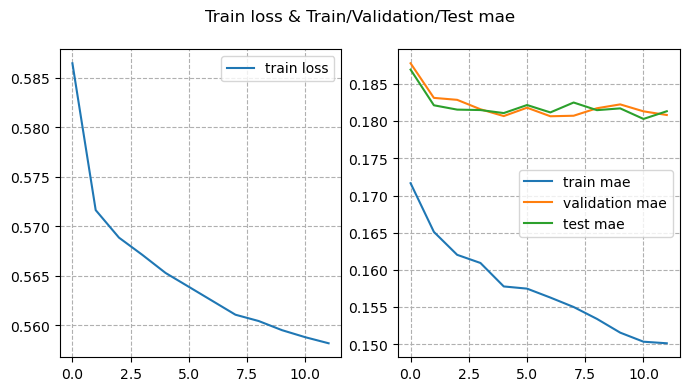

In [16]:
from matplotlib import pyplot as plt
metric_values = np.array(metric_values)
loss_values = [x[1] for x in loss_values]
f, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(loss_values, label="train loss")
ax[0].legend()
ax[0].grid(linestyle="--",which="major")

ax[1].plot(metric_values[:, 1], label="train mae")
ax[1].plot(metric_values[:, 2], label="validation mae")
ax[1].plot(metric_values[:, 3], label="test mae")
ax[1].legend()
ax[1].grid(linestyle="--",which="major")
plt.suptitle("Train loss & Train/Validation/Test mae")
plt.show()